In [ ]:
from google.colab import files

# Mengunggah file konfigurasi Kaggle API
uploaded = files.upload()

Saving kaggle.json to kaggle.json
Saving jazz.00054.wav to jazz.00054.wav


In [ ]:
import shutil
import os

# Memindahkan file ke direktori Kaggle di Colab
if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

'/root/.kaggle/kaggle.json'

In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.20G/1.21G [00:15<00:00, 72.8MB/s]
100% 1.21G/1.21G [00:15<00:00, 85.1MB/s]


In [ ]:

# Direktori tempat file-file dataset diunduh
download_dir = '/content'

!unzip gtzan-dataset-music-genre-classification.zip

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wa

In [ ]:
import os
import random
import librosa
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import keras
from keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy

In [ ]:
shutil.move('jazz.00054.wav', '/content/Data/genres_original/jazz/jazz.00054.wav')

'/content/Data/genres_original/jazz/jazz.00054.wav'

In [ ]:
dataset_path = '/content/Data/genres_original/'
SAMPLE_RATE = 22050
N_FFT = 2048  # 25ms frame length
WIN_LENGTH = int(SAMPLE_RATE * 0.025)
HOP_LENGTH = 512    # 10ms hop length
N_MFCC = 20  # Number of cepstral coefficients to be extracted
DURATION = 30  # Duration of each audio file
NUM_SEGMENTS = 10  # Number of segments per audio file
TEST_SPLIT = 0.2  # Percentage of test set

In [ ]:
# Fungsi untuk menghapus folder .ipynb_checkpoints secara rekursif
def remove_ipynb_checkpoints(directory):
    for dirpath, dirnames, filenames in os.walk(directory):
        for dirname in dirnames:
            if dirname == '.ipynb_checkpoints':
                checkpoint_dir = os.path.join(dirpath, dirname)
                shutil.rmtree(checkpoint_dir)

# Menghapus folder .ipynb_checkpoints dari dataset
remove_ipynb_checkpoints(dataset_path)

In [ ]:
preprocess = {
    "mapping" : [],
    "train" : {
        "features" : [],
        "labels" : []
    },
    "test" : {
        "features" : [],
        "labels" : []
    },
    "val" : {
        "features" : [],
        "labels" : []
    }
}

In [ ]:
def white_noice(audio, sr, expected_duration) :
  duration = librosa.get_duration(y=audio, sr=sr)
  noise = np.random.normal(0, audio.std(), audio.size)
  audio = audio + noise * 0.1  # 10% noise

  stretch_factor = len(audio) / (sr * expected_duration)
  audio = librosa.effects.time_stretch(y=audio, rate=stretch_factor)

  return audio

In [ ]:
def silent_remover(audio) :
  # Set amplitude threshold
  amplitude_threshold = 0.00316 # -50dB

  # Create an array of silent frames based on amplitude threshold
  silent_frames = np.abs(audio) < amplitude_threshold

  # Create an array of non-silent frames by inverting the silent frames
  non_silent_frames = np.logical_not(silent_frames)

  # Extract non-silent audio frames
  non_silent_audio = audio[non_silent_frames]

  # Calculate the time stretch factor
  stretch_factor = len(non_silent_audio) / (SAMPLE_RATE * DURATION)

  # Apply time stretching or compression
  stretched_audio = librosa.effects.time_stretch(y=non_silent_audio, rate=stretch_factor)

  return stretched_audio


In [ ]:
def process (audio) :
    dummy = []

    stretched_audio = silent_remover(audio)
    # print(len(stretched_audio))
    for s in range(NUM_SEGMENTS) :
        start_sample = s * len(stretched_audio) // NUM_SEGMENTS
        end_sample = (s + 1) * len(stretched_audio) // NUM_SEGMENTS
        # print(start_sample, end_sample)
        segment_audio = stretched_audio[start_sample:end_sample]
        dummy.append(segment_audio)

    return dummy

In [ ]:
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

    # Pastikan kita tidak berada di root level
    if dirpath is not dataset_path:
        # Simpan nama genre ke mapping
        dirpath_components = dirpath.split("/")
        semantic_label = dirpath_components[-1]
        preprocess["mapping"].append(semantic_label)
        print("\nProcessing {}".format(semantic_label))

        feature_dummies = []
        label_dummies = []

        # Proses file audio untuk tiap genre
        for f in filenames:
            # Load audio file
            file_path = os.path.join(dirpath, f)
            audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            # Process audio file
            audio = process(audio)

            for s,a in enumerate(audio) :
                feature_dummies.append(a)
                label_dummies.append(i-1)
                print("{}, segment:{}".format(file_path, s+1))

        # Split dataset menjadi training, validation, dan test set dengan train_test_split
        feature_train, feature_temp, label_train, label_temp = train_test_split(feature_dummies, label_dummies, test_size=TEST_SPLIT, random_state=42)
        feature_test, feature_val, label_test, label_val = train_test_split(feature_temp, label_temp, test_size=0.5, random_state=42)

        # Menambahkan data ke dalam dictionary
        preprocess["train"]["features"].extend(feature_train)
        preprocess["train"]["labels"].extend(label_train)
        preprocess["test"]["features"].extend(feature_test)
        preprocess["test"]["labels"].extend(label_test)
        preprocess["val"]["features"].extend(feature_val)
        preprocess["val"]["labels"].extend(label_val)


Output streaming akan dipotong hingga 5000 baris terakhir.
/content/Data/genres_original/reggae/reggae.00084.wav, segment:9
/content/Data/genres_original/reggae/reggae.00084.wav, segment:10
/content/Data/genres_original/reggae/reggae.00070.wav, segment:1
/content/Data/genres_original/reggae/reggae.00070.wav, segment:2
/content/Data/genres_original/reggae/reggae.00070.wav, segment:3
/content/Data/genres_original/reggae/reggae.00070.wav, segment:4
/content/Data/genres_original/reggae/reggae.00070.wav, segment:5
/content/Data/genres_original/reggae/reggae.00070.wav, segment:6
/content/Data/genres_original/reggae/reggae.00070.wav, segment:7
/content/Data/genres_original/reggae/reggae.00070.wav, segment:8
/content/Data/genres_original/reggae/reggae.00070.wav, segment:9
/content/Data/genres_original/reggae/reggae.00070.wav, segment:10
/content/Data/genres_original/reggae/reggae.00023.wav, segment:1
/content/Data/genres_original/reggae/reggae.00023.wav, segment:2
/content/Data/genres_original

In [ ]:
def mfcc(audio) :
  mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)

  delta_mfcc = librosa.feature.delta(mfcc)
  delta2_mfcc = librosa.feature.delta(mfcc, order=2)
  concanated_mfcc = np.vstack((mfcc, delta_mfcc, delta2_mfcc))
  concanated_mfcc = concanated_mfcc.T
  return concanated_mfcc.tolist()

In [ ]:
def mel_spectrogram(audio) :
  mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, win_length=WIN_LENGTH)
  mel_spectrogram_features = librosa.power_to_db(mel_spectrogram, ref=np.max)
  mel_spectrogram_features = mel_spectrogram_features.T

  return mel_spectrogram_features

In [ ]:
def pre_mfcc(signal):


    # Apply pre-emphasis filter
    pre_emphasis = 0.97
    emphasized_signal = np.append(
        signal[0], signal[1:] - pre_emphasis * signal[:-1])

    # Apply framing
    frame_size = 0.025
    frame_stride = 0.01
    frame_length, frame_step = frame_size * sr, frame_stride * sr
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(
        np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Apply windowing
    frames *= np.hamming(frame_length)

    # Apply Fourier Transform and Power Spectrum
    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Apply Mel filterbank
    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sr)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(
        filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)

    # Apply mean normalization
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

    return filter_banks

In [ ]:
def extract_mfcc(signal):
    # Apply Discrete Cosine Transform
    filter_banks = pre_mfcc(signal)
    num_ceps = 20
    mfcc = np.zeros((filter_banks.shape[0], num_ceps))
    for i in range(num_ceps):
        n = np.arange(filter_banks.shape[1])
        lift = 1 + (num_ceps / 2) * np.sin(np.pi * i / num_ceps)
        mfcc[:, i] = lift * \
            np.dot(filter_banks, np.cos(np.pi * i *
                   (n + 0.5) / filter_banks.shape[1]))


    delta_mfcc = librosa.feature.delta(mfcc)
    # delta2_mfcc = librosa.feature.delta(delta_mfcc, order=2)
    concanated_mfcc = np.hstack((mfcc, delta_mfcc))
    return concanated_mfcc

In [ ]:
np.array(preprocess["train"]["features"]).shape

(2400, 198450)

In [ ]:
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

for i in range(len(preprocess["train"]["features"])) :
    feature = preprocess["train"]["features"][i]
    label = preprocess["train"]["labels"][i]

    extraction = mfcc(feature)

    X_train.append(extraction)
    y_train.append(label)

for i in range(len(preprocess["val"]["features"])) :
    feature = preprocess["val"]["features"][i]
    label = preprocess["val"]["labels"][i]

    extraction = mfcc(feature)

    X_val.append(extraction)
    y_val.append(label)

for i in range(len(preprocess["test"]["features"])) :
    feature = preprocess["test"]["features"][i]
    label = preprocess["test"]["labels"][i]

    extraction = mfcc(feature)

    X_test.append(extraction)
    y_test.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(8000, 130, 60)
(1000, 130, 60)
(1000, 130, 60)


In [ ]:
def build_model(input_shape):
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(625, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(512))

    # Dense layer
    model.add(keras.layers.Dense(512, activation="relu"))

    model.add(keras.layers.Dense(256, activation="relu"))

    model.add(keras.layers.Dense(128, activation="relu"))

    model.add(keras.layers.Dense(64, activation="relu"))


    # Output layer
    model.add(keras.layers.Dense(10, activation="softmax"))

    return model

In [ ]:
def plot_history(history):

        fig, axs = plt.subplots(2)

        # create accuracy subplot
        axs[0].plot(history.history["accuracy"], label="train accuracy")
        axs[0].plot(history.history["val_accuracy"], label="test accuracy")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend(loc="lower right")
        axs[0].set_title("Accuracy eval")

        # margin top
        fig.subplots_adjust(top=1.4, bottom=0.1, left=0.10, right=0.95)

        # create error subplot
        axs[1].plot(history.history["loss"], label="train error")
        axs[1].plot(history.history["val_loss"], label="test error")
        axs[1].set_ylabel("Error")
        axs[1].set_xlabel("Epoch")
        axs[1].legend(loc="upper right")
        axs[1].set_title("Error eval")

        plt.show()


In [ ]:
# X = np.array(data["mfcc"])
# y = np.array(data["labels"])

# print(X.shape)

In [ ]:
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# # Pisah data sisa menjadi data validasi (50%) dan data pengujian (50%)
# X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# print(X_train.shape)
# print(X_test.shape)
# print(X_validation.shape)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

# compile model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

# add callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='/content/models/jurnal.h5', save_best_only=True)

# train model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=64, epochs=30, callbacks=[early_stopping, model_checkpoint])




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 130, 625)          1715000   
                                                                 
 lstm_3 (LSTM)               (None, 512)               2330624   
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 10)               

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 10s 83ms/step - loss: 1.2390 - accuracy: 0.5543 - val_loss: 1.2004 - val_accuracy: 0.5820
Epoch 3/30
125/125 [==============================] - 11s 86ms/step - loss: 1.0521 - accuracy: 0.6314 - val_loss: 1.0770 - val_accuracy: 0.6160
Epoch 4/30
125/125 [==============================] - 11s 85ms/step - loss: 0.9151 - accuracy: 0.6768 - val_loss: 1.0261 - val_accuracy: 0.6670
Epoch 5/30
125/125 [==============================] - 11s 86ms/step - loss: 0.7784 - accuracy: 0.7312 - val_loss: 0.8703 - val_accuracy: 0.7040
Epoch 6/30
125/125 [==============================] - 11s 86ms/step - loss: 0.6500 - accuracy: 0.7806 - val_loss: 0.7403 - val_accuracy: 0.7420
Epoch 7/30
125/125 [==============================] - 11s 87ms/step - loss: 0.5639 - accuracy: 0.8024 - val_loss: 0.7975 - val_accuracy: 0.7310
Epoch 8/30
125/125 [==============================] - 11s 88ms/step - loss: 0.4610 - accuracy: 0.8439 - val_loss: 0.7306 - val_accuracy: 0.7870
Epo

32/32 [==============================] - 1s 23ms/step - loss: 0.6295 - accuracy: 0.8350
Train accuracy: 96.84%
Train loss:  9.75%
Validation accuracy: 82.20%
Validation loss: 75.90%
Test accuracy: 83.50%
Test loss: 62.95%


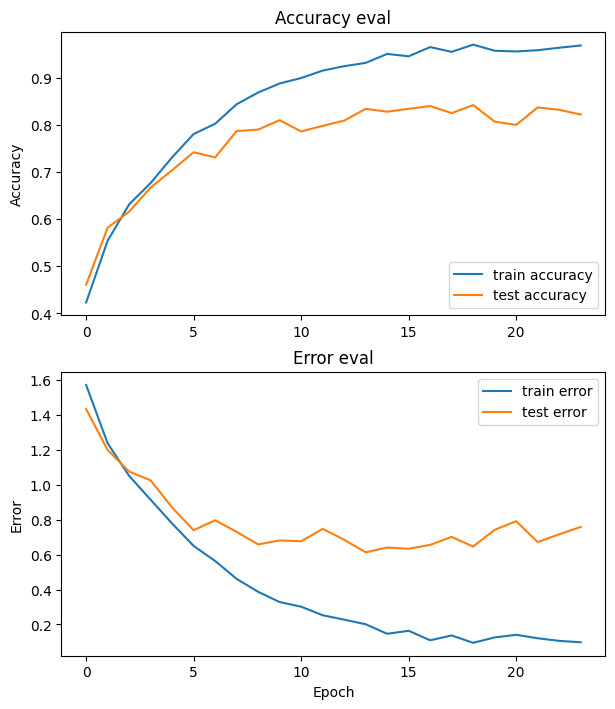

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
print("Train accuracy: {:5.2f}%".format(100 * train_acc[-1]))
print("Train loss: {:5.2f}%".format(100 * train_loss[-1]))
print("Validation accuracy: {:5.2f}%".format(100 * val_acc[-1]))
print("Validation loss: {:5.2f}%".format(100 * val_loss[-1]))
print("Test accuracy: {:5.2f}%".format(100 * test_acc))
print("Test loss: {:5.2f}%".format(100 * test_loss))
plot_history(history)

32/32 [==============================] - 2s 22ms/step
Confusion Matrix:


<Axes: >

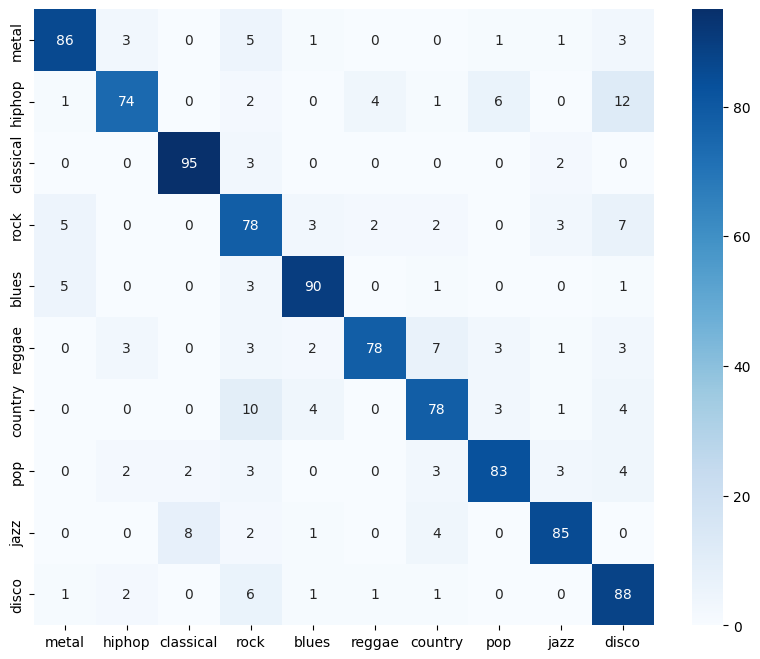

In [ ]:
y_pred = model.predict(X_test)
genre_labels = preprocess['mapping']
confusion = confusion_matrix(y_test, y_pred.argmax(axis=1))
print('Confusion Matrix:')

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=genre_labels, yticklabels=genre_labels)

In [ ]:
print('Classification Report')

print(classification_report(y_test, y_pred.argmax(axis=1), target_names=genre_labels))

Classification Report
              precision    recall  f1-score   support

       metal       0.88      0.86      0.87       100
      hiphop       0.88      0.74      0.80       100
   classical       0.90      0.95      0.93       100
        rock       0.68      0.78      0.73       100
       blues       0.88      0.90      0.89       100
      reggae       0.92      0.78      0.84       100
     country       0.80      0.78      0.79       100
         pop       0.86      0.83      0.85       100
        jazz       0.89      0.85      0.87       100
       disco       0.72      0.88      0.79       100

    accuracy                           0.83      1000
   macro avg       0.84      0.83      0.84      1000
weighted avg       0.84      0.83      0.84      1000



In [ ]:
# BACKUP
/'''
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

    # Pastikan kita tidak berada di root level
    if dirpath is not dataset_path:

        # Simpan nama genre ke mapping
        dirpath_components = dirpath.split("/")
        semantic_label = dirpath_components[-1]
        data["mapping"].append(semantic_label)
        print("\nProcessing {}".format(semantic_label))

        # Loop melalui semua file audio (format .wav)
        for f in filenames:

            # Load audio file
            file_path = os.path.join(dirpath, f)
            audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            # Set amplitude threshold
            amplitude_threshold = 0.00316 # -50dB

            # Create an array of silent frames based on amplitude threshold
            silent_frames = np.abs(audio) < amplitude_threshold

            # Create an array of non-silent frames by inverting the silent frames
            non_silent_frames = np.logical_not(silent_frames)

            # Extract non-silent audio frames
            non_silent_audio = audio[non_silent_frames]

            # Calculate the time stretch factor
            stretch_factor = len(non_silent_audio) / (sr * DURATION)

            # Apply time stretching or compression
            stretched_audio = librosa.effects.time_stretch(y=non_silent_audio, rate=stretch_factor)

            # Extract MFCC features for each segment
            for s in range(NUM_SEGMENTS):
                start_sample = s * len(stretched_audio) // NUM_SEGMENTS
                end_sample = (s + 1) * len(stretched_audio) // NUM_SEGMENTS
                segment_audio = stretched_audio[start_sample:end_sample]

                mfcc = librosa.feature.mfcc(y=segment_audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=40, htk=True, dct_type=2)[:20]

                delta_mfcc = librosa.feature.delta(mfcc)

                concanated_mfcc = np.vstack((mfcc, delta_mfcc))
                concanated_mfcc = concanated_mfcc.T
                data["mfcc"].append(concanated_mfcc.tolist())
                data["labels"].append(i-1)
                print("{}, segment:{}".format(file_path, s+1))
'''/
